# Regression-based Forecasting

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

## 실습 data: Amtrak.csv
- 철도 회사 Amtrak의 1991년 1월부터 2004년 3월까지의 매달 승객 수 데이터를 이용하여 미래의 승객 수를 예측해보고자 함
- Ridership= Amtrak Ridership Number of Passengers (in thousands)

##### Amtrak.csv 파일을 읽어오시오.
- Month의 데이터 타입을 datetime으로 변경한 column을 추가하시오. (column name = Date)

In [2]:
Amtrak_df = pd.read_csv('./data/Amtrak.csv')
Amtrak_df.head()

,Month,Ridership
0,01/01/1991,1708.917
1,01/02/1991,1620.586
2,01/03/1991,1972.715
3,01/04/1991,1811.665
4,01/05/1991,1974.964


In [4]:
Amtrak_df = pd.read_csv('./data/Amtrak.csv')
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format="%d/%m/%Y")
Amtrak_df

,Month,Ridership,Date
0,01/01/1991,1708.917,1991-01-01
1,01/02/1991,1620.586,1991-02-01
2,01/03/1991,1972.715,1991-03-01
3,01/04/1991,1811.665,1991-04-01
4,01/05/1991,1974.964,1991-05-01
...,...,...,...
154,01/11/2003,2076.054,2003-11-01
155,01/12/2003,2140.677,2003-12-01
156,01/01/2004,1831.508,2004-01-01
157,01/02/2004,1838.006,2004-02-01


##### Date와 Ridership을 가지는 Series 데이터를 만드시오.

In [5]:
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date, name='Ridership')
ridership_ts

Date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
                ...   
2003-11-01    2076.054
2003-12-01    2140.677
2004-01-01    1831.508
2004-02-01    1838.006
2004-03-01    2132.446
Name: Ridership, Length: 159, dtype: float64

## Linear trend

##### 위 Series에 trend column을 추가하여 DataFrame으로 만드시오.
- tsatools.add_trend 함수 활용
- $Y_t=\beta_0+\beta_1t+\epsilon$를 만족하는 선형식을 찾기 위한 과정
- add_trend를 통해서 생성해준 trend 값이 t를 의미하고, $\beta_1$을 구하기 위한 것이며, const가 $\beta_0$를 구하기 위한 것

In [6]:
from statsmodels.tsa import tsatools

In [10]:
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_df

,Ridership,const,trend
Date,,,
1991-01-01,1708.917,1.0,1.0
1991-02-01,1620.586,1.0,2.0
1991-03-01,1972.715,1.0,3.0
1991-04-01,1811.665,1.0,4.0
1991-05-01,1974.964,1.0,5.0
...,...,...,...
2003-11-01,2076.054,1.0,155.0
2003-12-01,2140.677,1.0,156.0
2004-01-01,1831.508,1.0,157.0


##### 위 DataFrame을 선형 회귀 분석 모델에 fit 하시오.
- sm.ols 함수 활용

In [11]:
import statsmodels.formula.api as sm

In [12]:
ridership_lm = sm.ols(formula='Ridership ~ trend', data=ridership_df).fit()

##### 시간에 따른 ridership 변화 그래프와 위 선형 회귀 분석을 통해 나온 예측 그래프를 함께 출력하시오.

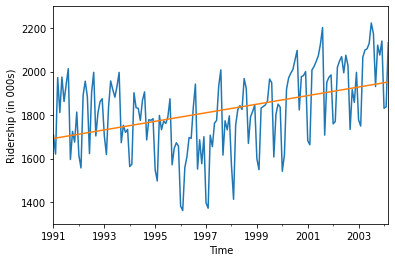

In [14]:
ridership_ts.plot()
# 선형 회귀 분석 예측 그래프 출력
ridership_lm.predict(ridership_df).plot()
plt.xlabel('Time')
plt.ylabel('Ridership (in 000s)')
plt.ylim(1300, 2300)
plt.show()

##### 위 DataFrame을 train, valid set으로 나누시오.
- train : valid = 123 : 36 (총 데이터 길이가 159임)
- 앞의 123개의 데이터를 이용해서 학습하고 뒤의 36개를 맞춰보는 형식

In [16]:
ridership_df.head(2)

,Ridership,const,trend
Date,,,
1991-01-01,1708.917,1.0,1.0
1991-02-01,1620.586,1.0,2.0


In [17]:
nValid = 36
nTrain = len(ridership_ts) - nValid

train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

##### 아래 주어진 그래프 그리는 함수들을 활용하여 선형 회귀 분석 모델을 통한 결과 그래프를 그리시오.
- 실제 Ridership과 선형 회귀 모형 함께 그리기 (Train, Valid 구분)

In [18]:
# train set을 선형 회귀 분석 모델에 fit
ridership_lm_linear = sm.ols(formula='Ridership ~ trend', data=train_df).fit()

train만 가지고 선형 모델을 만들면 거의 constant 함수에 가까움, test 부분의 trend도 잘 반영하지 못하는 것으로 보임

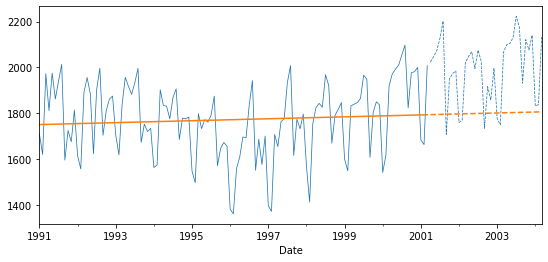

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
# 원 데이터 plot
train_df.plot(y='Ridership', ax=axes, color='C0', linewidth=0.75)
valid_df.plot(y='Ridership', ax=axes, color='C0', linestyle='dashed', linewidth=0.75)
# 위에서 생성한 모델에 각각 train set과 valid set을 넣고 선형 회귀 분석을 통해 나온 그래프 출력
ridership_lm_linear.predict(train_df).plot(ax=axes, color='C1')
ridership_lm_linear.predict(valid_df).plot(ax=axes, color='C1', linestyle='dashed')
plt.legend().set_visible(False)

## Exponential Trend
- $Y_t = ce^{\beta_0 + \beta_1t + \epsilon}$
- $logY_t = \beta_0 +\beta_1t + \epsilon + logc$ => $logY_t = \beta_0 + \beta_1t + \epsilon$
- y 값에 log를 취한 후에 선형 식을 도출

##### 위에 주어진 그래프 그리는 함수들을 활용하여 선형 회귀 분석 모델을 통한 결과 그래프를 그리시오.
- 실제 Ridership과 선형 회귀 모형 함께 그리기 (단순 Trend Model과 Exponential Trend Model 선형 회귀 예측 그래프 모두)

In [20]:
# train set을 선형 회귀 분석 모델에 fit (Exponential Trend Model)
ridership_lm_expo = sm.ols(formula='np.log(Ridership) ~ trend', data=train_df).fit()
#predict_df_expo = ridership_lm_expo.predict(valid_df)

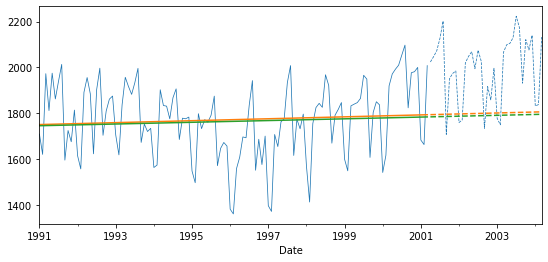

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,4))
# train, valid set 그리기
train_df.plot(y='Ridership', ax=axes, color='C0', linewidth=0.75)
valid_df.plot(y='Ridership', ax=axes, color='C0', linestyle='dashed', linewidth=0.75)

# 단순 Trend Model 그래프
ridership_lm_linear.predict(train_df).plot(color='C1')
ridership_lm_linear.predict(valid_df).plot(color='C1', linestyle='dashed')

# Exponential Trend Model 그래프
ridership_lm_expo.predict(train_df).apply(lambda x: math.exp(x)).plot(color='C2')
ridership_lm_expo.predict(valid_df).apply(lambda x: math.exp(x)).plot(color='C2', 
                                                                          linestyle='dashed')
plt.legend().set_visible(False)

plt.show()

##### 왜 linear trend와 exponential trend 사이에 별 차이가 없는지? 
- exponential trend는 y 값에 log를 취해서 보면, log 취한 값의 형태도 원래 데이터랑 큰 차이 없음
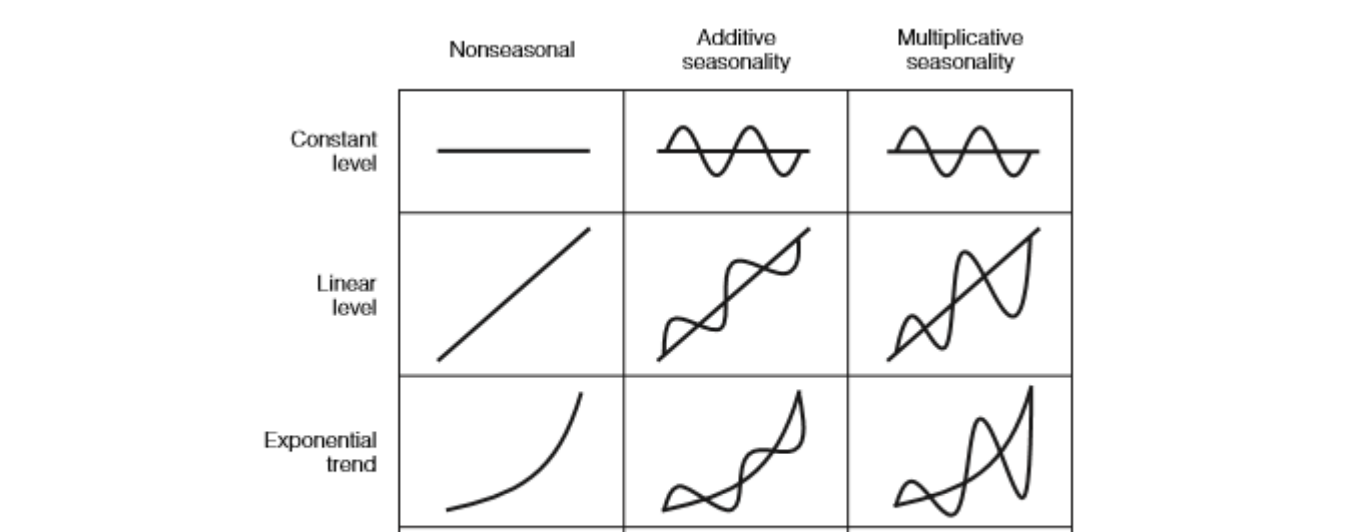

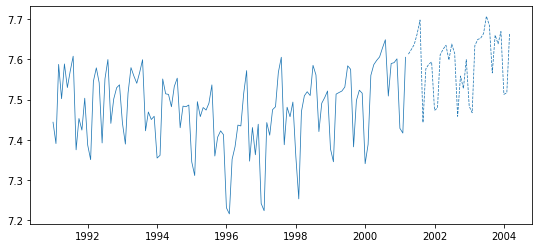

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,4))
# log-scaled train, valid set 그리기
axes.plot(np.log(train_df.Ridership), color='C0', linewidth=0.75)
axes.plot(np.log(valid_df.Ridership), color='C0', linestyle='dashed', linewidth=0.75)

## Polynomial trend
- $Y_t=\beta_{0}+\beta_{1}t+\beta_{2}t^2+\epsilon$ (quadratic trend model)

##### 위에 주어진 그래프 그리는 함수들을 활용하여 선형 회귀 분석 모델을 통한 결과 그래프를 그리시오.
- 실제 Ridership과 선형 회귀 모형 함께 그리기 (Quadratic trend model)

In [22]:
# train set을 선형 회귀 분석 모델에 fit (Exponential Trend Model)
ridership_lm_poly = sm.ols(formula='Ridership ~ trend + np.square(trend)', 
                           data=train_df).fit()

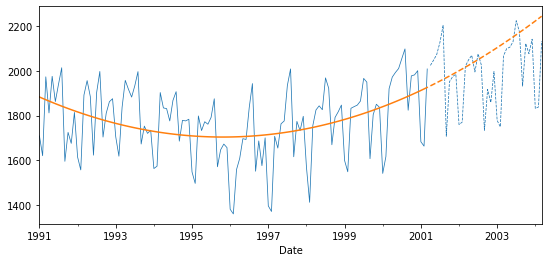

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

# train, valid set 그리기
train_df.plot(y='Ridership', ax=axes, color='C0', linewidth=0.75)
valid_df.plot(y='Ridership', ax=axes, color='C0', linestyle='dashed', linewidth=0.75)

# Quadratic Trend Model 그래프
ridership_lm_poly.predict(train_df).plot(ax=axes, color='C1')
ridership_lm_poly.predict(valid_df).plot(ax=axes, color='C1', linestyle='dashed')
plt.legend().set_visible(False)

plt.show()

## A Model with Seasonality

##### 새로운 categorical variable로 달 (Month)을 추가하시오.
- seasonality만 분석하기 위해 trend는 제외
- 달이 ridership을 예측하는 변수로 사용 (categorical 변수로 사용해야 함)

In [26]:
ridership_df = tsatools.add_trend(ridership_ts, trend='c')
ridership_df['Month'] = ridership_df.index.month
ridership_df

,Ridership,const,Month
Date,,,
1991-01-01,1708.917,1.0,1
1991-02-01,1620.586,1.0,2
1991-03-01,1972.715,1.0,3
1991-04-01,1811.665,1.0,4
1991-05-01,1974.964,1.0,5
...,...,...,...
2003-11-01,2076.054,1.0,11
2003-12-01,2140.677,1.0,12
2004-01-01,1831.508,1.0,1


##### 위 DataFrame을 train, valid set으로 나누시오.
- train : valid = 123 : 36

In [27]:
nValid = 36
nTrain = len(ridership_ts) - nValid

train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

##### 위에 주어진 그래프 그리는 함수들을 활용하여 회귀 분석 모델을 통한 결과 그래프를 그리시오.
- 실제 Ridership과 seasonality 반영 선형 회귀 모형 함께 그리기 (Train, Valid 구분)

In [28]:
# train set을 회귀 분석 모델에 fit
ridership_lm_season = sm.ols(formula='Ridership ~ C(Month)', data=train_df).fit()

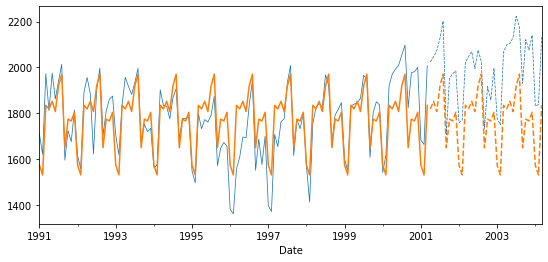

In [29]:
# 결과 그래프 그리기
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

# train, valid set 그리기
train_df.plot(y='Ridership', ax=axes, color='C0', linewidth=0.75)
valid_df.plot(y='Ridership', ax=axes, color='C0', linestyle='dashed', linewidth=0.75)

# 위에서 생성한 모델에 각각 train set과 valid set을 넣고 회귀 분석을 통해 나온 그래프 출력
ridership_lm_season.predict(train_df).plot(ax=axes, color='C1')
ridership_lm_season.predict(valid_df).plot(ax=axes, color='C1', linestyle='dashed')
plt.legend().set_visible(False)
plt.show()

## A Model with Trend and Seasonality

##### 새로운 categorical variable로 달 (Month)을 추가하시오.
- trend와 seasonaliyt를 모두 고려하는 모델을 만들기 위해서

In [30]:
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_df['Month'] = ridership_df.index.month
ridership_df

,Ridership,const,trend,Month
Date,,,,
1991-01-01,1708.917,1.0,1.0,1
1991-02-01,1620.586,1.0,2.0,2
1991-03-01,1972.715,1.0,3.0,3
1991-04-01,1811.665,1.0,4.0,4
1991-05-01,1974.964,1.0,5.0,5
...,...,...,...,...
2003-11-01,2076.054,1.0,155.0,11
2003-12-01,2140.677,1.0,156.0,12
2004-01-01,1831.508,1.0,157.0,1


##### 위 DataFrame을 train, valid set으로 나누시오.
- train : valid = 123 : 36

In [31]:
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

##### 위에 주어진 그래프 그리는 함수들을 활용하여 회귀 분석 모델을 통한 결과 그래프를 그리시오.
- 실제 Ridership과 seasonality, Trend 반영 회귀 모형 함께 그리기 (Train, Valid 구분)

In [32]:
# train set을 회귀 분석 모델에 fit
# Ridership ~ trend + np.square(trend) + C(Month)
ridership_lm_trendseason = sm.ols(formula='Ridership ~ trend + np.square(trend) + C(Month)', 
                                  data=train_df).fit()

In [38]:
valid_df

,Ridership,const,trend,Month
Date,,,,
2001-04-01,2023.792,1.0,124.0,4
2001-05-01,2047.008,1.0,125.0,5
2001-06-01,2072.913,1.0,126.0,6
2001-07-01,2126.717,1.0,127.0,7
2001-08-01,2202.638,1.0,128.0,8
2001-09-01,1707.693,1.0,129.0,9
2001-10-01,1950.716,1.0,130.0,10
2001-11-01,1973.614,1.0,131.0,11
2001-12-01,1984.729,1.0,132.0,12


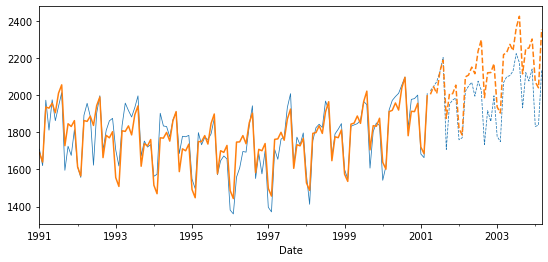

In [33]:
# 결과 그래프 그리기
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

# train, valid set 그리기
train_df.plot(y='Ridership', ax=axes, color='C0', linewidth=0.75)
valid_df.plot(y='Ridership', ax=axes, color='C0', linestyle='dashed', linewidth=0.75)

# 위에서 생성한 모델에 각각 train set과 valid set을 넣고 회귀 분석을 통해 나온 그래프 출력
ridership_lm_trendseason.predict(train_df).plot(ax=axes, color='C1')
ridership_lm_trendseason.predict(valid_df).plot(ax=axes, color='C1', linestyle='dashed')

plt.legend().set_visible(False)
plt.show()

$y_t = ay_{t-1} + by_{t-2}$

## Computing Autocorrelation
- 이전 y값과 어떤 관계가 있는지 파악
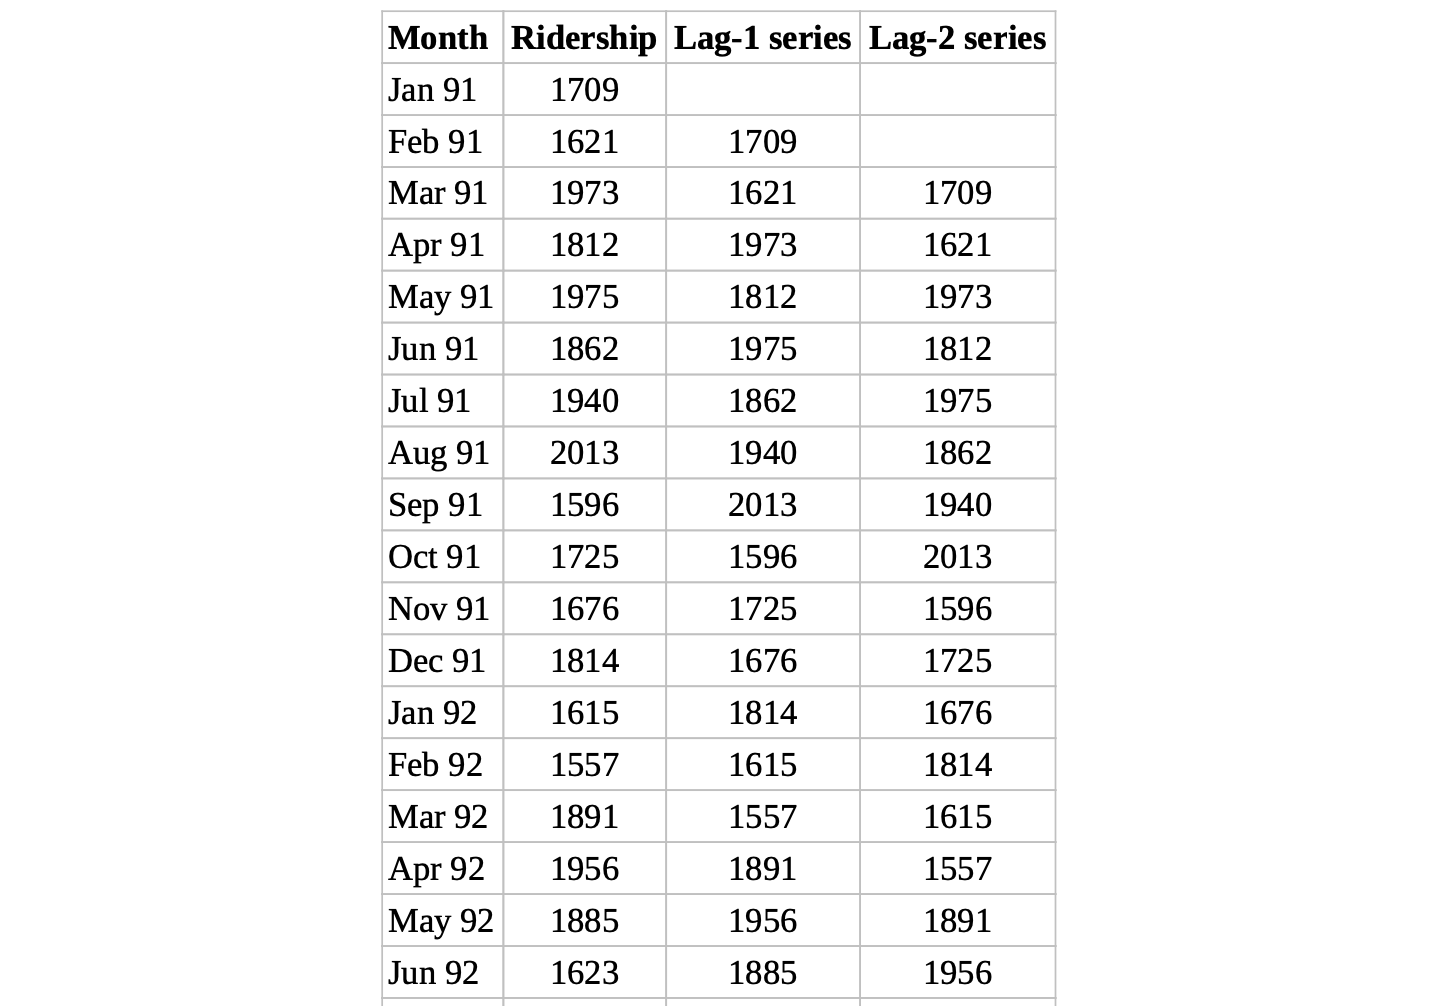

##### train_df를 이용하여 Ridership에 대해 자기상관 (Autocorrelation) 그래프를 그리시오.

In [34]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa import tsatools, stattools

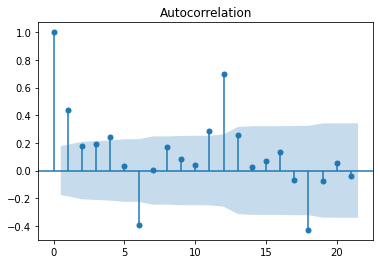

In [35]:
tsaplots.plot_acf(train_df.Ridership, use_vlines=True)
plt.show()

In [36]:
print(stattools.acf(train_df.Ridership))

[ 1.          0.43872098  0.17440154  0.18889302  0.24527127  0.0321974
 -0.39228696  0.00608866  0.17158445  0.08472183  0.04050189  0.28454935
  0.69797494  0.25431686  0.0270157   0.06894593  0.13380246 -0.06828804
 -0.42937074 -0.07340318  0.05536794 -0.03960817 -0.02630983  0.20773508
  0.54326914  0.14465667 -0.0299595   0.00494948  0.01660544 -0.16977298
 -0.49154993 -0.15229365 -0.05919248 -0.15044143 -0.1309199   0.06980442
  0.3805373   0.01939476 -0.0993833  -0.06107535 -0.04376899]


/root/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/root/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


##### 위 seasonality와 trend를 반영한 회귀 분석 모델의 예측값과 실제 Ridership 값 차이에 대해 자기상관(Autocorrelation) 그래프를 그리시오.

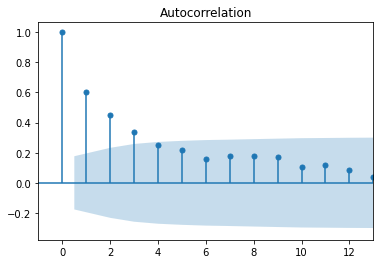

In [37]:
residual = train_df.Ridership - ridership_lm_trendseason.predict(train_df)
tsaplots.plot_acf(residual)
plt.xlim(-1, 13)
plt.show()